In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from numpy.polynomial import Polynomial as P
from PIL import Image
%matplotlib inline

PREV_LEFT_X1 = None
PREV_LEFT_X2 = None
PREV_RIGHT_X1 = None
PREV_RIGHT_X2 = None

BASE_IMG = None
CANNY_IMG = None

In [2]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')

In [3]:
#print('This image is:', type(image), 'with dimesions:', image.shape)
#image = Image.open(image).convert("L")
#plt.imshow(image, cmap='gray')  

In [4]:
import math

def to_hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def filter_color(img):
    yellow_min = np.array([65, 80, 80], np.uint8)
    yellow_max = np.array([105, 255, 255], np.uint8)
    yellow_mask = cv2.inRange(img, yellow_min, yellow_max)

    white_min = np.array([0, 0, 200], np.uint8)
    white_max = np.array([255, 80, 255], np.uint8)
    white_mask = cv2.inRange(img, white_min, white_max)

    img = cv2.bitwise_and(img, img, mask=cv2.bitwise_or(yellow_mask, white_mask))
    return img

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def slope(line):
    return (float(line[3]) - line[1]) / (float(line[2]) - line[0])


def draw_lines(img, lines, color=[255, 0, 0], thickness=7):
    global PREV_LEFT_X1, PREV_LEFT_X2, PREV_RIGHT_X1, PREV_RIGHT_X2
    left_x = []
    left_y = []
    right_x = []
    right_y = []

    for line in lines:
        line = line[0]
        s = slope(line)

        if 0.3 > s > -0.3:
            continue

        if s < 0:
            if line[0] > img.shape[1] / 2 + 40:
                continue

            left_x += [line[0], line[2]]
            left_y += [line[1], line[3]]
            # cv2.line(img, (int(line[0]), int(line[1])), (int(line[2]), int(line[3])), [0, 0, 255], thickness)
        else:
            if line[0] < img.shape[1] / 2 - 40:
                continue

            right_x += [line[0], line[2]]
            right_y += [line[1], line[3]]
            # cv2.line(img, (int(line[0]), int(line[1])), (int(line[2]), int(line[3])), [255, 255, 0], thickness)

    y1 = img.shape[0]
    y2 = img.shape[0] / 2 + 90

    if len(left_x) <= 1 or len(right_x) <= 1:
        if PREV_LEFT_X1 is not None:
            cv2.line(img, (int(PREV_LEFT_X1), int(y1)), (int(PREV_LEFT_X2), int(y2)), color, thickness)
            cv2.line(img, (int(PREV_LEFT_X2), int(y1)), (int(PREV_RIGHT_X2), int(y2)), color, thickness)
        return

    left_poly = P.fit(np.array(left_x), np.array(left_y), 1)
    right_poly = P.fit(np.array(right_x), np.array(right_y), 1)

    left_x1 = (left_poly - y1).roots()
    right_x1 = (right_poly - y1).roots()

    left_x2 = (left_poly - y2).roots()
    right_x2 = (right_poly - y2).roots()

    if PREV_LEFT_X1 is not None:
        left_x1 = PREV_LEFT_X1 * 0.7 + left_x1 * 0.3
        left_x2 = PREV_LEFT_X2 * 0.7 + left_x2 * 0.3
        right_x1 = PREV_RIGHT_X1 * 0.7 + right_x1 * 0.3
        right_x2 = PREV_RIGHT_X2 * 0.7 + right_x2 * 0.3

    PREV_LEFT_X1 = left_x1
    PREV_LEFT_X2 = left_x2
    PREV_RIGHT_X1 = right_x1
    PREV_RIGHT_X2 = right_x2

    cv2.line(img, (int(left_x1), int(y1)), (int(left_x2), int(y2)), color, thickness)
    cv2.line(img, (int(right_x1), int(y1)), (int(right_x2), int(y2)), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=1., β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [5]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

In [35]:
Image_list=os.listdir("test_images/")
hsv_images=[]
t="test_images/"

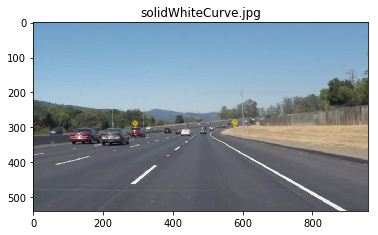

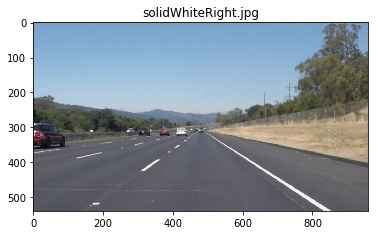

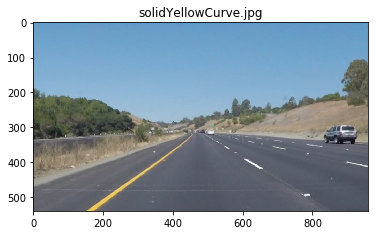

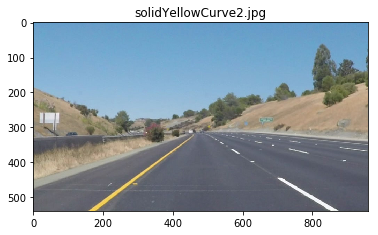

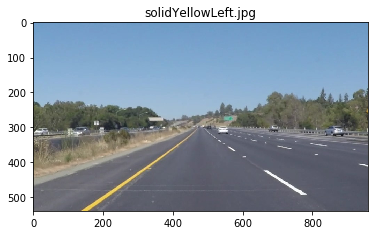

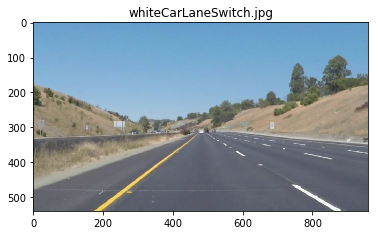

In [102]:
for im in Image_list:
    ims=mpimg.imread(t+im)
    plt.title(im)
    plt.imshow(ims)
    plt.figure()
    i_h=to_hsv(ims)
    hsv_images.append(i_h)

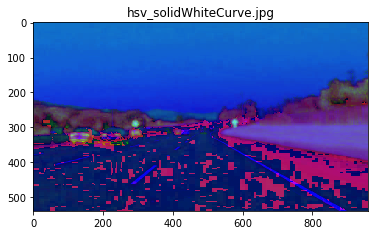

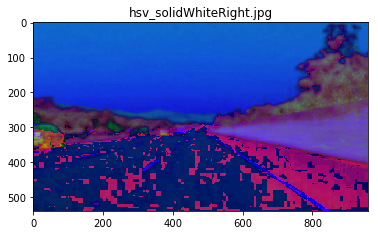

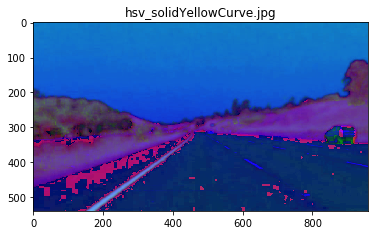

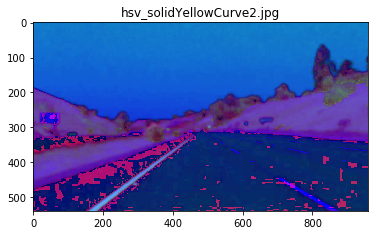

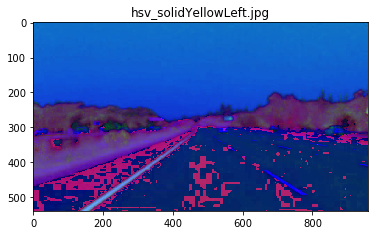

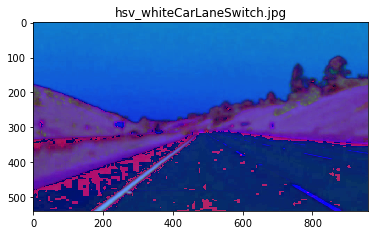

In [103]:
#print(len(hsv_images))
for i in range(len(Image_list)):
    plt.imshow(hsv_images[i],cmap='gray');
    plt.title('hsv_'+Image_list[i])
    plt.figure()

In [129]:
gs_images=[] # gaussian blur image list
for i in range(len(Image_list)):
    gs=grayscale(hsv_images[i])
    gs_images.append(gs)

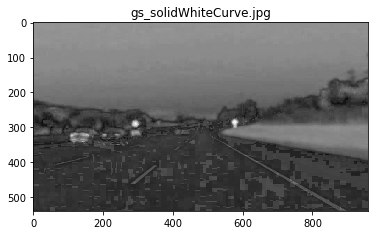

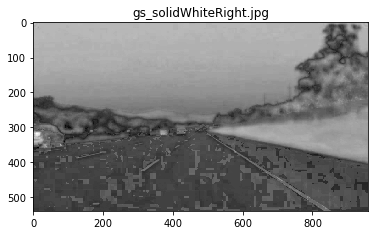

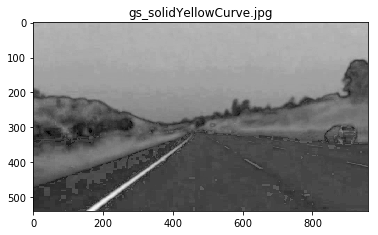

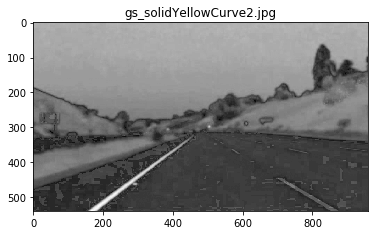

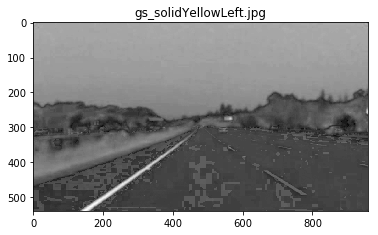

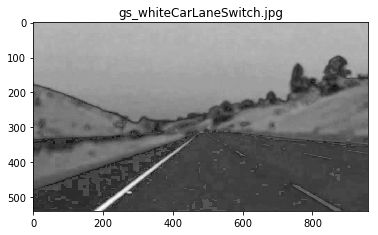

In [130]:
for i in range(len(Image_list)):
    plt.imshow(gs_images[i],cmap='gray')
    plt.title('gs_'+Image_list[i])
    plt.figure()

canny_images=[] 
for i in range(len(Image_list)):
    canny_1=canny(gs_images[i],93,183)
    canny_images.append(canny_1)

In [133]:
canny_images=[] 
for i in range(len(Image_list)): 
    canny_1=canny(gs_images[i],73,196) 
    canny_images.append(canny_1)


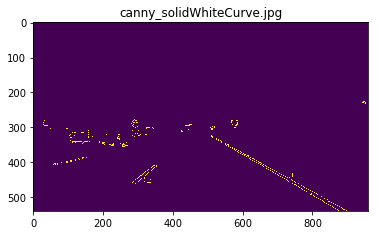

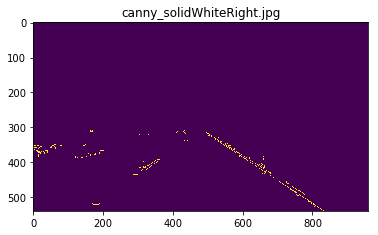

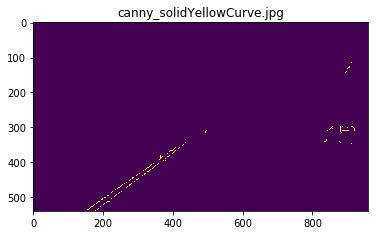

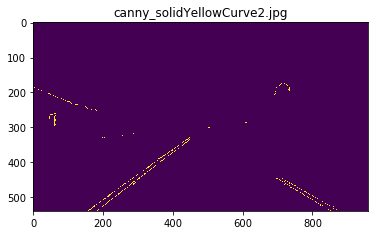

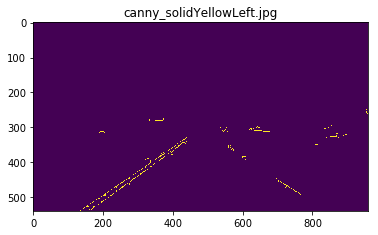

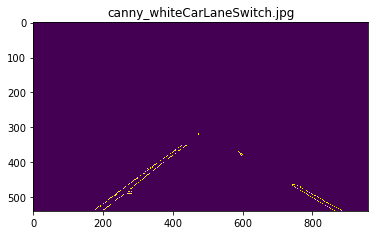

In [134]:
for i in range(len(Image_list)):
    plt.imshow(canny_images[i])
    plt.title('canny_'+Image_list[i])
    plt.figure()